In [9]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
import numpy as np
import warnings

In [10]:
# ปิดการแจ้งเตือนค่าคงที่
warnings.filterwarnings("ignore")

In [11]:
# Set the display options to prevent line wrapping and truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [12]:
data = pd.read_csv(r"csv\dataset_malwares.csv")

X = data.drop(['Name','Malware','SuspiciousImportFunctions','SuspiciousNameSection','TimeDateStamp'], axis=1)
y = data['Malware']

In [13]:
models = RandomForestClassifier()

In [14]:
def info_gain(k_mins, k_maxs, X, y, model, seed, cv):

    k_min = k_mins
    k_max = k_maxs

    results = []
    k_values = []
    accuracy_values = []

    f = open(f"result_text/info_gain/Info_RF_seed{seed}.txt", "w+")
    
    for k in range(k_min, k_max):

        selector = SelectKBest(mutual_info_classif, k=k)
        selector.fit(X, y)

        cols = selector.get_support(indices=True)

        X_select = X.iloc[:,cols]

        kf = KFold(n_splits=cv, random_state=seed, shuffle=True)

        scores = cross_val_score(model, X_select, y, cv=kf, scoring='accuracy')

        accuracy_score = scores.mean()

        k_values.append(k)
        accuracy_values.append(accuracy_score)
        results.append([k, accuracy_score])

        f.write('\n')
        f.write(f'ACC = {accuracy_score} K = {k} {X_select.columns.tolist()}')

    headers = ["K", "Accuracy"]
    f.write('\n')
    f.write(tabulate(results, headers, tablefmt="pretty"))
    f.close()

    plt.figure(figsize=(20, 6))
    plt.plot(k_values, accuracy_values, marker='.', linestyle='-')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title(f'Information Gain - RF, seed = {seed}')
    plt.xticks(range(k_min, k_max))
    plt.grid(True)

    save_path = f"result_graph/info_gain/Info_RF_seed{seed}"
    plt.savefig(save_path)
    plt.close()

    return k_values, accuracy_values, k_max, selector

In [15]:
def main():

    f = open(f"result_text/average_result/Info_RF_seed1-100.txt", "w+")    
    all_accuracy_values = []

    for seeds in range(1, 101):
        k_vals, acc_vals, k_maxs, selectors = info_gain(k_mins=1, k_maxs=75, X=X, y=y, model=models, seed=seeds, cv=10)
        all_accuracy_values.append(acc_vals)

    all_accuracy_values_array = np.array(all_accuracy_values)

    average_accuracies = all_accuracy_values_array.mean(axis=0)

    features_score = pd.DataFrame(selectors.scores_)
    features = pd.DataFrame(X.columns)
    feature_score = pd.concat([features,features_score],axis=1)

    feature_score.columns = ["Input_Features","Score"]
    print(feature_score.nlargest(75,columns="Score"))
    f.write(feature_score.nlargest(75, columns="Score").to_string(index=False))

    average_results = list(zip(range(1, k_maxs + 1), average_accuracies))
    headers = ["K", "Average Accuracy 1-100 seed"]

    print('\n')
    print(tabulate(average_results, headers, tablefmt="pretty"))

    f.write('\n')
    f.write(tabulate(average_results, headers, tablefmt="pretty"))
    f.close()
    
    plt.figure(figsize=(20, 6))
    plt.plot(k_vals, average_accuracies, marker='.', linestyle='-')
    plt.xlabel('k')
    plt.ylabel('Average Accuracy 1-100 seed')
    plt.title(f'Information Gain - RF, Sample group 100 seeds')
    plt.xticks(range(1, k_maxs))
    plt.grid(True)
    save_path = f"result_graph/average_result/Info_RF_seed1-100"
    plt.savefig(save_path)
    plt.show()

                  Input_Features     Score
44            DllCharacteristics  0.343307
22               Characteristics  0.336245
35   MinorOperatingSystemVersion  0.286852
37             MinorImageVersion  0.286543
38         MajorSubsystemVersion  0.269715
31                     ImageBase  0.268324
24            MajorLinkerVersion  0.260078
45            SizeOfStackReserve  0.252804
70     ImageDirectoryEntryImport  0.244794
39         MinorSubsystemVersion  0.236685
34   MajorOperatingSystemVersion  0.233083
52             SectionMinEntropy  0.231266
56         SectionMinVirtualsize  0.212866
43                     Subsystem  0.201672
41                      CheckSum  0.199186
58            SectionMaxPhysical  0.194145
29           AddressOfEntryPoint  0.183014
54             SectionMinRawsize  0.180330
27         SizeOfInitializedData  0.172502
69     ImageDirectoryEntryExport  0.151570
68          DirectoryEntryExport  0.138383
62         SectionMaxPointerData  0.136677
67      Dir

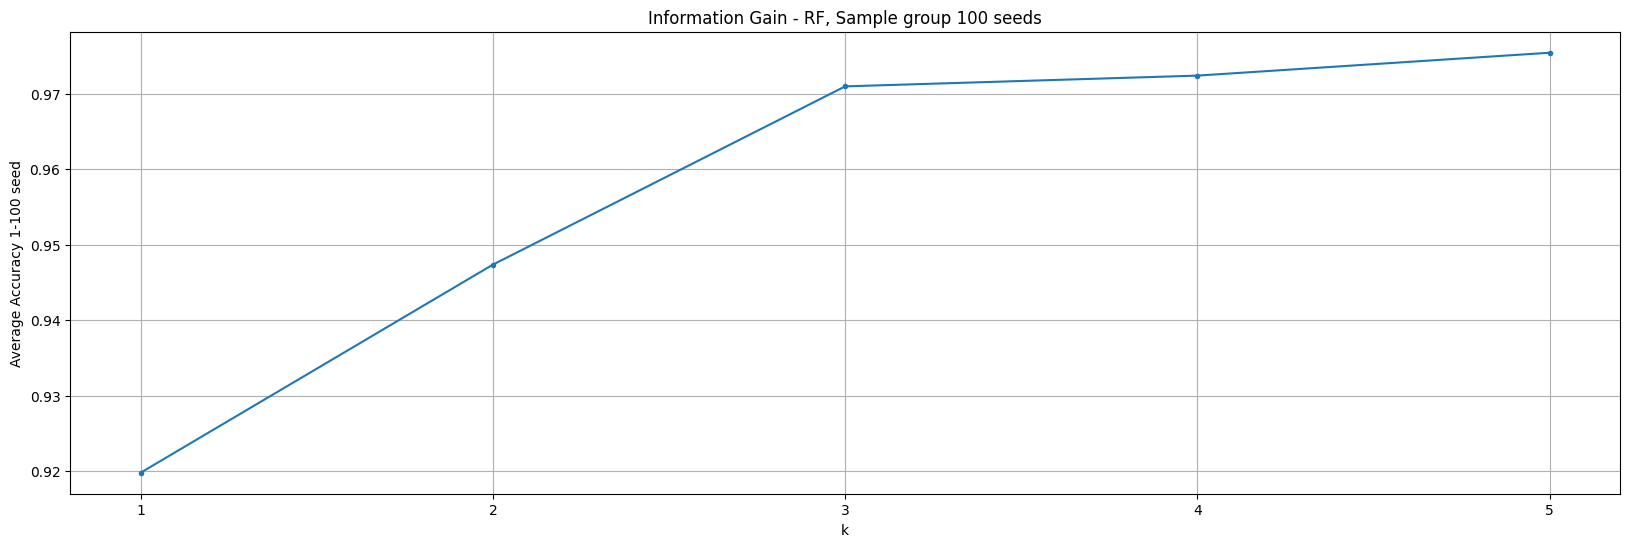

In [16]:
main()